In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kf_book.book_plots as book_plots
from kf_book.mkf_internal import plot_track
from filterpy.stats import plot_covariance_ellipse

In [2]:
import math
from numpy.random import randn

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

## The Kalman Filter Equations

### Prediction Equations
The Kalman filter uses these equations to compute the prior - the predicted next state of the system. They compute the prior mean ($\bar{\mathbf x}$) and covariance ($\bar{\mathbf P}$) of the system.

$$\begin{aligned}
\mathbf{\bar x} &= \mathbf{Fx} + \mathbf{Bu}\\
\mathbf{\bar P} &= \mathbf{FPF}^\mathsf T + \mathbf Q
\end{aligned}$$
$\underline{\textbf{Mean}}$

$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$

As a reminder, the linear equation $\mathbf{Ax} = \mathbf b$ represents a system of equations, where $\mathbf A$ holds the coefficients set of equations, $\mathbf x$ is the vector of variables. Performing the multiplication $\mathbf{Ax}$ computes the right hand side values for that set of equations, represented by  $\mathbf b$.

If $\mathbf F$ contains the state transition for a given time step, then the product $\mathbf{Fx}$ computes the state after that transition. Easy! Likewise, $\mathbf B$ is the control function, $\mathbf u$ is the control input, so $\mathbf{Bu}$ computes the contribution of the controls to the state after the transition. Thus, the prior $\mathbf{\bar x}$ is computed as the sum of $\mathbf{Fx}$ and $\mathbf{Bu}$.

If you perform the matrix multiplication $\mathbf{Fx}$ it generates this equation for $x$.

Let's make this explicit. Recall the value for $\mathbf F$ from the last chapter:

$$\mathbf F = \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}$$
Thus $\mathbf{\bar x} = \mathbf{Fx}$ corresponds to the set of linear equations:

$$\begin{cases}
\begin{aligned}
\bar x &= 1x + &\Delta t\, \dot x \\
\bar{\dot x} &=0x + &1\, \dot x
\end{aligned}
\end{cases}$$
$\underline{\textbf{Covariance}}$

$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q$

This equation is not as easy to understand so we will spend more time on it.

In univariate version of this equation is:

$$\bar\sigma^2 = \sigma^2 + \sigma^2_{move}$$
We add the variance of the movement to the variance of our estimate to reflect the loss of knowlege. We need to do the same thing here, except it isn't quite that easy with multivariate Gaussians.

We can't simply write $\mathbf{\bar P} = \mathbf P + \mathbf Q$. In a multivariate Gaussians the state variables are correlated. What does this imply? Our knowledge of the velocity is imperfect, but we are adding it to the position with

$$\bar x = \dot x\Delta t + x$$
Since we do not have perfect knowledge of the value of $\dot x$ the sum $\bar x = \dot x\Delta t + x$ gains uncertainty. Because the positions and velocities are correlated we cannot simply add the covariance matrices. For example, if $\mathbf P$ and $\mathbf Q$ are diagonal matrices the sum would also be diagonal. But we know position is correlated to velocity so the off-diagonal elements should be non-zero.

The correct equation is

$$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q$$
Expressions in the form $\mathbf{ABA}^\mathsf T$ are common in linear algebra. You can think of it as projecting the middle term by the outer term. We will be using this many times in the rest of the book. I admit this may be a 'magical' equation to you. Let's explore it.

When we initialize $\mathbf P$ with

$$\mathbf P = \begin{bmatrix}\sigma^2_x & 0 \\ 0 & \sigma^2_v\end{bmatrix}$$
the value for $\mathbf{FPF}^\mathsf T$ is:

$$\begin{aligned}
\mathbf{FPF}^\mathsf T &= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\begin{bmatrix}\sigma^2_x & 0 \\  0 & \sigma^2_{v}\end{bmatrix}
\begin{bmatrix}1&0\\\Delta t&1\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x&\sigma_v^2\Delta t\\  0 & \sigma^2_{v}\end{bmatrix}
\begin{bmatrix}1&0\\\Delta t&1\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x +  \sigma_v^2\Delta t^2  &  \sigma_v^2\Delta t \\
\sigma_v^2\Delta t & \sigma^2_{v}\end{bmatrix}
\end{aligned}$$
The initial value for $\mathbf P$ had no covariance between the position and velocity. Position is computed as $\dot x\Delta t + x$, so there is a correlation between the position and velocity. The multiplication $\mathbf{FPF}^\mathsf T$ computes a covariance of $\sigma_v^2 \Delta t$. The exact value is not important; you just need to recognize that $\mathbf{FPF}^\mathsf T$ uses the process model to automatically compute the covariance between the position and velocity!

Another way to think of this is to reflect on the $\mathbf{Fx}$ multiplication. That projected $\mathbf x$ forward in time. $\mathbf {FP}$ might seem to be the equivalent operation, but $\mathbf P$ is a matrix while $\mathbf x$ is a vector. The trailing $\mathbf F^\mathsf T$ term ensures that we multiply by both the rows and columns of $\mathbf F$. In the second line of the computation of $\mathbf{FPF}^\mathsf T$ we have the value for $\mathbf{FP}$. You can see that it is an upper triangular matrix because we haven't fully incorporated $\mathbf F$ into the multiplication.

If you have some experience with linear algebra and statistics, this may help. The covariance due to the prediction can be modeled as the expected value of the error in the prediction step, given by this equation.

$$\begin{aligned}
\bar{\mathbf P} &= \mathbb E[(\mathbf{Fx})(\mathbf{Fx})^\mathsf T]\\
 &= \mathbb E[\mathbf{Fxx}^\mathsf T\mathbf F^\mathsf T] \\
 &= \mathbf F\, \mathbb E[\mathbf{xx}^\mathsf T]\, \mathbf F^\mathsf T
\end{aligned}$$
Of course, $\mathbb E[\mathbf{xx}^\mathsf T]$ is just $\mathbf P$, giving us

$$\bar{\mathbf P} = \mathbf{FPF}^\mathsf T$$
Let's look at its effect. Here I use $\mathbf F$ from our filter and project the state forward 6/10ths of a second. I do this five times so you can see how $\mathbf{\bar P}$ continues to change.

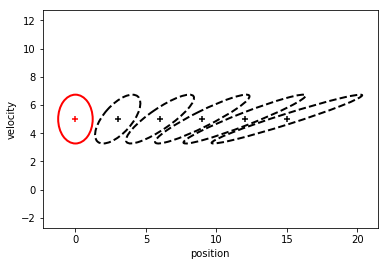

In [3]:
dt = 0.6
x = np.array([0., 5.])
F = np.array([[1., dt], [0, 1.]])
P = np.array([[1.5, 0], [0, 3.]])
plot_covariance_ellipse(x, P, edgecolor='r')

for _ in range(5):
    x = np.dot(F, x)
    P = np.dot(F, P).dot(F.T)
    plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')
book_plots.set_labels(x='position', y='velocity')

### Update Equations

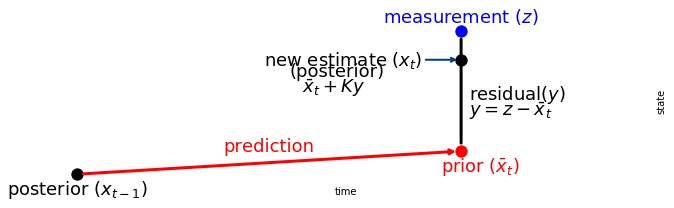

In [4]:
book_plots.show_residual_chart()

$\underline{\textbf{System Uncertainty}}$

$\textbf{S} = \mathbf{H\bar PH}^\mathsf T + \mathbf R$

To work in measurement space the Kalman filter has to project the covariance matrix into measurement space. The math for this is $\mathbf{H\bar PH}^\mathsf T$, where $\mathbf{\bar P}$ is the prior covariance and $\mathbf H$ is the measurement function.

You should recognize this $\mathbf{ABA}^\mathsf T$ form - the prediction step used $\mathbf{FPF}^\mathsf T$ to update $\mathbf P$ with the state transition function. Here, we use the same form to update it with the measurement function. The linear algebra is changing the coordinate system for us.

Once the covariance is in measurement space we need to account for the sensor noise. This is very easy - we just add matrices. The result is variously called the *system uncertainty* or *innovation covariance*.

If you ignore the $\mathbf H$ term this equation is the equivalent to the denominator in the univariate equation for the Kalman gain:

$$K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2}$$
Compare the equations for the system uncertainty and the covariance

$$\begin{aligned}
\mathbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R\\
\mathbf{\bar P} &= \mathbf{FPF}^\mathsf T + \mathbf Q
\end{aligned}$$
In each equation $\mathbf P$ is put into a different space with either the function $\mathbf H$ or $\mathbf F$. Then we add the noise matrix associated with that space.

$\underline{\textbf{Kalman Gain}}$

$\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}$

Look back at the residual diagram. Once we have a prediction and a measurement we need to select an estimate somewhere between the two. If we have more certainty about the measurement the estimate will be closer to it. If instead we have more certainty about the prediction then the estimate will be closer to it.

For the multivariate Kalman filter $\mathbf K$ is a vector, not a scalar. Here is the equation again: $\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}$. Is this a ratio? We can think of the inverse of a matrix as linear algebra's way of finding the reciprocal. Division is not defined for matrices, but it is useful to think of it in this way. So we can read the equation for $\textbf{K}$ as meaning

$$\begin{aligned} \mathbf K &\approx \frac{\mathbf{\bar P}\mathbf H^\mathsf T}{\mathbf{S}} \\
\mathbf K &\approx \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T
\end{aligned}$$
The Kalman gain equation computes a ratio based on how much we trust the prediction vs the measurement. We did the same thing in every prior chapter. The equation is complicated because we are doing this in multiple dimensions via matrices, but the concept is simple. The $\mathbf H^\mathsf T$ term is less clear, I'll explain it soon. If you ignore that term the equation for the Kalman gain is the same as the univariate case: divide the uncertainty of the prior with the of the sum of the uncertainty of the prior and measurement.

$\underline{\textbf{Residual}}$

$\mathbf y = \mathbf z - \mathbf{H\bar{x}}$

This is an easy one as we've covered this equation while designing the measurement function $\mathbf H$. Recall that the measurement function converts a state into a measurement. So $\mathbf{Hx}$ converts $\mathbf x$ into an equivalent measurement. Once that is done, we can subtract it from the measurement $\mathbf z$ to get the residual - the difference between the measurement and prediction.


$\underline{\textbf{State Update}}$

$\mathbf x = \mathbf{\bar x} + \mathbf{Ky}$

We select our new state to be along the residual, scaled by the Kalman gain. The scaling is performed by $\mathbf{Ky}$, which both scales the residual and converts it back into state space with the $\mathbf H^\mathsf T$ term which is in $\mathbf K$. This is added to the prior, yielding the equation: $\mathbf x =\mathbf{\bar x} + \mathbf{Ky}$. Let me write out $\mathbf K$ so we can see the entire computation:

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} + \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}\mathbf y \\
&\approx \mathbf{\bar x} + \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T\mathbf y
\end{aligned}$$
$\underline{\textbf{Covariance Update}}$

$\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}$

$\mathbf{I}$ is the identity matrix, and is the way we represent $1$ in multiple dimensions. $\mathbf H$ is our measurement function, and is a constant. We can think of the equation as $\mathbf P = (1-c\mathbf K)\mathbf P$. $\mathbf K$ is our ratio of how much prediction vs measurement we use. If $\mathbf K$ is large then $(1-\mathbf{cK})$ is small, and $\mathbf P$ will be made smaller than it was. If $\mathbf K$ is small, then $(1-\mathbf{cK})$ is large, and $\mathbf P$ will be relatively larger. This means that we adjust the size of our uncertainty by some factor of the Kalman gain.

This equation can be numerically unstable and I don't use it in FilterPy. Later I'll share more complicated but numerically stable forms of this equation.

### An Example not using FilterPy

Here we initialize our matrices:

In [5]:
from filterpy.common import Q_discrete_white_noise

dt = 1.
R_var = 10
Q_var = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

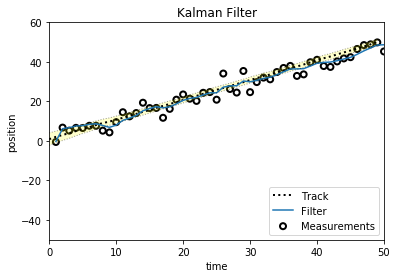

In [6]:
from numpy import dot
from scipy.linalg import inv

count = 50
track, zs = compute_dog_data(R_var, Q_var, count)
xs, cov = [], []
for z in zs:
    # predict
    x = dot(F, x)
    P = dot(F, P).dot(F.T) + Q
    
    #update
    S = dot(H, P).dot(H.T) + R
    K = dot(P, H.T).dot(inv(S))
    y = z - dot(H, x)
    x += dot(K, y)
    P = P - dot(K, H).dot(P)
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:, 0], track, zs, cov, plot_P=False, dt=dt)

### Summary
We have learned the Kalman filter equations. Here they are all together for your review. There was a lot to learn, but I hope that as you went through each you recognized it's kinship with the equations in the univariate filter. In the Kalman Math chapter I will show you that if we set the dimension of $\mathbf x$ to one that these equations revert back to the equations for the univariate filter. This is not "like" the univariate filter - it is a multidimensional implementation of it.

$$
\begin{aligned}
\text{Predict Step}\\
\mathbf{\bar x} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{\bar P} &= \mathbf{FP{F}}^\mathsf T + \mathbf Q \\
\\
\text{Update Step}\\
\textbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
\mathbf K &= \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
\textbf{y} &= \mathbf z - \mathbf{H \bar x} \\
\mathbf x &=\mathbf{\bar x} +\mathbf{K\textbf{y}} \\
\mathbf P &= (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}
\end{aligned}
$$
I want to share a form of the equations that you will see in the literature. There are many different notation systems used, but this gives you an idea of what to expect.

$$
\begin{aligned}
\hat{\mathbf x}_{k\mid k-1} &= \mathbf F_k\hat{\mathbf x}_{k-1\mid k-1} + \mathbf B_k \mathbf u_k  \\
\mathbf P_{k\mid k-1} &=  \mathbf F_k \mathbf P_{k-1\mid k-1} \mathbf F_k^\mathsf T + \mathbf Q_k \\            
\tilde{\mathbf y}_k &= \mathbf z_k - \mathbf H_k\hat{\mathbf x}_{k\mid k-1}\\
\mathbf{S}_k &= \mathbf H_k \mathbf P_{k\mid k-1} \mathbf H_k^\mathsf T + \mathbf R_k \\
\mathbf K_k &= \mathbf P_{k\mid k-1}\mathbf H_k^\mathsf T \mathbf{S}_k^{-1}\\
\hat{\mathbf x}_{k\mid k} &= \hat{\mathbf x}_{k\mid k-1} + \mathbf K_k\tilde{\mathbf y}_k\\
\mathbf P_{k|k} &= (I - \mathbf K_k \mathbf H_k) \mathbf P_{k|k-1}
\\\end{aligned}
$$

This notation uses the Bayesian $a\mid b$ notation, which means $a$ given the evidence of $b$. The hat means estimate. Thus $\hat{\mathbf x}_{k\mid k}$ means the estimate of the state $\mathbf x$ at step $k$ (the first k) given the evidence from step $k$ (the second k). The posterior, in other words. $\hat{\mathbf x}_{k\mid k-1}$ means the estimate for the state $\mathbf x$ at step $k$ given the estimate from step $k - 1$. The prior, in other words.